In [2]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import joblib
import os



## Open master df

In [10]:
# Open master
df_train= pd.read_feather('../data/processed/train_data.feather')
df_test= pd.read_feather('../data/processed/test_data.feather')


In [3]:
# Calculate average price per route
route_avg_price = (
    df_train.groupby(['startingAirport', 'destinationAirport'])['totalFare']
    .mean()
    .reset_index()
    .rename(columns={'totalFare': 'average_price'})
)

# Merge this back to the original dataset
df_train = df_train.merge(route_avg_price, on=['startingAirport', 'destinationAirport'], how='left')
df_test = df_test.merge(route_avg_price, on=['startingAirport', 'destinationAirport'], how='left')

In [4]:
# merge average distance to the dataset
route_avg_distance = (
    df_train.groupby(['startingAirport', 'destinationAirport'])['totalTravelDistance']
    .mean()
    .reset_index()
    .rename(columns={'totalTravelDistance': 'average_distance'})
)

df_train = df_train.merge(route_avg_distance, on=['startingAirport', 'destinationAirport'], how='left')
df_test = df_test.merge(route_avg_distance, on=['startingAirport', 'destinationAirport'], how='left')



In [11]:
# Calculate unique routes in the dataset
# Create a new column to represent the unique route, combining airports alphabetically, store as string
def unique_route(df):
    df['route'] = df[['startingAirport', 'destinationAirport']].apply(
        lambda x: str(tuple(sorted(x))), axis=1
    )
    return df

df_train = unique_route(df_train)
df_test = unique_route(df_test)

# number of unique routes
unique_routes = df_train['route'].nunique()

# Modelling

Steps
1. Encode the categories
2. Normalise
3. Split and train
4. train 
5. Eval

### Preprocess data

In [17]:

# Preprocess the features
# Define the features and target
def preprocess_xy(df):
    X = df.drop(['totalFare', 'searchDate', 'flightDate','segmentsArrivalAirportCode'], axis=1)
    y = df['totalFare']
    return X, y

#Label encode for airports
def process_airports(df):
    le = LabelEncoder()
    all_airports = sorted(set(df['startingAirport']).union(df['destinationAirport']))
    le.fit(all_airports)
    
    df['startingAirport'] = le.transform(df['startingAirport'])
    df['destinationAirport'] = le.transform(df['destinationAirport'])
    # print dictionary of the label encoder for airports with original values and the encoded values
    print(dict(zip(le.classes_, le.transform(le.classes_))))

    return df, le

def process_routes(df):
    le_route = LabelEncoder()
    df['route'] = le_route.fit_transform(df['route'])

    return df, le_route

def process_airports_test(df):

    df['startingAirport'] = le.transform(df['startingAirport'])
    df['destinationAirport'] = le.transform(df['destinationAirport'])
    return df
    
def process_routes_test(df):

    df['route'] = le_route.transform(df['route'])

    return df

#Features to process
boolean_cols = ['isNonStop']
ohe_cols = ['AirlineNameScore', 'CabinCode']
scale_cols = ['DepartureTimeHour','date_diff_days', 'CabinCode'] #'average_distance', 'average_price'
scale_cols = list(set(scale_cols) - set(ohe_cols))

# Encode the boolean column
def process_boolean(df):
    df[boolean_cols] = df[boolean_cols].astype(int)
    return df

# scale data
def process_scale(df):
    scaler = StandardScaler()
    df[scale_cols] = scaler.fit_transform(df[scale_cols])
    return df, scaler

def process_scale_test(df):
    df[scale_cols] = scaler.transform(df[scale_cols])
    return df

# weekday to get cos and sine
def process_weekday(df):
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
    df.drop('weekday', axis=1, inplace=True)
    return df

# onehot encode cabin code
def process_ohe(df):
    print("Columns before one-hot encoding:", df.columns)
    print("Columns to one-hot encode:", ohe_cols)
    df = pd.get_dummies(df, columns=ohe_cols)
    return df

# Preprocess the features
def preprocess_features(df):
    df, le = process_airports(df)
    
    print('processairport',df.columns)
    df, le_route = process_routes(df)
    df = process_boolean(df)
    print('processboolean',df.columns)
    df = process_weekday(df)
    print('processweekday',df.columns)
    df = process_ohe(df)
    print('processohe',df.columns)
    df, scaler = process_scale(df)
    print('processscale',df.columns)
    
    return df, le, le_route, scaler

def preprocess_features_test(df):
    df = process_airports_test(df)
    df = process_routes_test(df)
    print('after process route',df.head(5))
    df = process_boolean(df)
    df = process_weekday(df)
    df = process_ohe(df)
    df = process_scale_test(df)
    return df



In [18]:
X_train, y_train = preprocess_xy(df_train)
X_test, y_test = preprocess_xy(df_test)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train, le, le_route, scaler = preprocess_features(X_train)
X_val= preprocess_features_test(X_val)
X_test= preprocess_features_test(X_test)




{'ATL': 0, 'BOS': 1, 'CLT': 2, 'DEN': 3, 'DFW': 4, 'DTW': 5, 'EWR': 6, 'IAD': 7, 'JFK': 8, 'LAX': 9, 'LGA': 10, 'MIA': 11, 'OAK': 12, 'ORD': 13, 'PHL': 14, 'SFO': 15}
processairport Index(['startingAirport', 'destinationAirport', 'isNonStop',
       'totalTravelDistance', 'DepartureTimeHour', 'CabinCode',
       'AirlineNameScore', 'date_diff_days', 'weekday', 'route'],
      dtype='object')
processboolean Index(['startingAirport', 'destinationAirport', 'isNonStop',
       'totalTravelDistance', 'DepartureTimeHour', 'CabinCode',
       'AirlineNameScore', 'date_diff_days', 'weekday', 'route'],
      dtype='object')
processweekday Index(['startingAirport', 'destinationAirport', 'isNonStop',
       'totalTravelDistance', 'DepartureTimeHour', 'CabinCode',
       'AirlineNameScore', 'date_diff_days', 'route', 'weekday_sin',
       'weekday_cos'],
      dtype='object')
Columns before one-hot encoding: Index(['startingAirport', 'destinationAirport', 'isNonStop',
       'totalTravelDistance',

## LightGBM

In [ ]:
# run lightgbm on X_train without pipeline
# X_train only added route
LGBM_Model = LGBMRegressor()
LGBM_Model.fit(X_train, y_train)
y_pred = LGBM_Model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = root_mean_squared_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {mse}')






[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 516
[LightGBM] [Info] Number of data points in the train set: 4085281, number of used features: 20
[LightGBM] [Info] Start training from score 324.383684
Mean Absolute Error: 77.11938777656525
Root Mean Squared Error: 111.37812033789321


In [ ]:
# run lightgbm on X_train without pipeline
# added everything to X_train and updated the encoder to use transform for test data
LGBM_Model = LGBMRegressor()
LGBM_Model.fit(X_train, y_train)
y_pred = LGBM_Model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mse = root_mean_squared_error(y_val, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {mse}')






[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 781
[LightGBM] [Info] Number of data points in the train set: 4085281, number of used features: 21
[LightGBM] [Info] Start training from score 324.383684
Mean Absolute Error: 75.76413197218578
Root Mean Squared Error: 109.3503856109872


In [86]:
# run lightgbm on X_train without pipeline
# added avg distance to X_train

LGBM_Model.fit(X_train, y_train)
y_pred = LGBM_Model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mse = root_mean_squared_error(y_val, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {mse}')






[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 584
[LightGBM] [Info] Number of data points in the train set: 4085281, number of used features: 14
[LightGBM] [Info] Start training from score 324.383684
Mean Absolute Error: 76.41341201293545
Root Mean Squared Error: 109.88549823368791


In [71]:
# run lightgbm on X_train without pipeline
# added avg price to X_train and scaled

LGBM_Model.fit(X_train, y_train)
y_pred = LGBM_Model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mse = root_mean_squared_error(y_val, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {mse}')






[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 4085281, number of used features: 14
[LightGBM] [Info] Start training from score 324.383684
Mean Absolute Error: 76.27222708142749
Root Mean Squared Error: 110.37135170347902


In [59]:
# run lightgbm on X_train without pipeline
# added avg price to X_train

LGBM_Model.fit(X_train, y_train)
y_pred = LGBM_Model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mse = root_mean_squared_error(y_val, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {mse}')






[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 4085281, number of used features: 14
[LightGBM] [Info] Start training from score 324.383684
Mean Absolute Error: 76.25749352803882
Root Mean Squared Error: 110.36215100443175


In [53]:
# run lightgbm on X_train without pipeline

LGBM_Model.fit(X_train, y_train)
y_pred = LGBM_Model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mse = root_mean_squared_error(y_val, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {mse}')






[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 395
[LightGBM] [Info] Number of data points in the train set: 4085281, number of used features: 13
[LightGBM] [Info] Start training from score 324.383684
Mean Absolute Error: 77.89776747094626
Root Mean Squared Error: 111.7761029843885


In [8]:
# Define the preprocessor

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", AirportToNumTransformer(), airport_features),
        ("bool", BooleanToIntTransformer(), boolean_features),
    ]
)

# Define the model
# lightgbm
LGBM_Model = LGBMRegressor()

# Define the pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", LGBM_Model)])
# Run the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mse = root_mean_squared_error(y_val, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {mse}')

# Save the model
joblib.dump(pipeline, '../models/LGBM/LGBM_model.pkl')

# Save the preprocessor
joblib.dump(preprocessor, '../models/LGBM/preprocessor.pkl')

# Save the label encoder
joblib.dump(airport_features_transformer, '../models/LGBM/airport_features_transformer.pkl')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 4085281, number of used features: 7
[LightGBM] [Info] Start training from score 324.383684
Mean Absolute Error: 87.78749918965357
Root Mean Squared Error: 123.38477288799227


['../models/LGBM/airport_features_transformer.pkl']

### With OHE

In [46]:

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", AirportToNumTransformer(), airport_features),
        ("onehot", OneHotEncoderTransformer, airport_features),
        ("bool", BooleanToIntTransformer(), boolean_features),
    ]
)

# Define the model
# lightgbm
LGBM_Model = LGBMRegressor()

# Define the pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", LGBM_Model)])

# Run the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mse = root_mean_squared_error(y_val, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {mse}')

# # Save the model
# joblib.dump(pipeline, '../models/LGBM/LGBM_model.pkl')

# # Save the preprocessor
# joblib.dump(preprocessor, '../models/LGBM/preprocessor.pkl')

# # Save the label encoder
# joblib.dump(airport_features_transformer, '../models/LGBM/airport_features_transformer.pkl')



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 4085281, number of used features: 36
[LightGBM] [Info] Start training from score 324.383684
Mean Absolute Error: 85.97394308847606
Root Mean Squared Error: 121.49106963116407


In [43]:
# Preprocess the features for the entire original DataFrame
X_full, _ = preprocess_xy(df_train)
X_full_transformed = pipeline.named_steps['preprocessor'].transform(X_full)

# Make predictions on the preprocessed features
y_full_pred = pipeline.named_steps['model'].predict(X_full_transformed)

# Ensure the length of predictions matches the length of the original DataFrame
assert len(y_full_pred) == len(df_train), "Length of predictions does not match length of the original DataFrame"

# Append predictions to the original DataFrame
df_train['totalFare_pred'] = y_full_pred
df_train['totalFare_pred'] = df_train['totalFare_pred'].clip(0, None)



NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

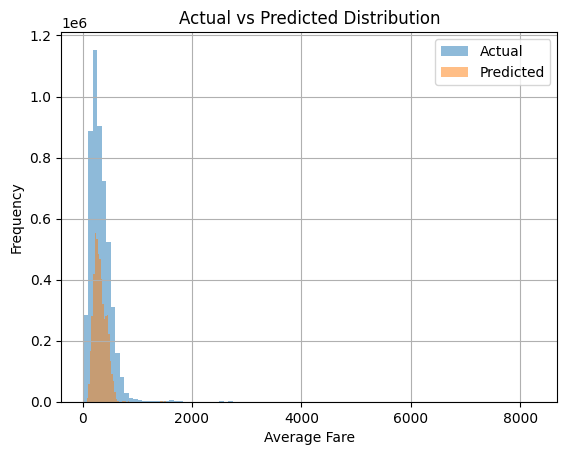

NameError: name 'd' is not defined

In [12]:
# plot the actual vs predicted
import matplotlib.pyplot as plt
# plt.scatter(df_train['totalFare'], df_train['totalFare_pred'])
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.xlim(0, 5000)
# plt.ylim(0, 5000)
# plt.title('Actual vs Predicted')
# plt.show()

#plot the actual distribution for avg fare and predicted distribution for avg fare grouped by AirlineNameScore
df_train['totalFare'].hist(bins=100, alpha=0.5, label='Actual')
df_train['totalFare_pred'].hist(bins=100, alpha=0.5, label='Predicted')
plt.legend()
plt.xlabel('Average Fare')
plt.ylabel('Frequency')
plt.title('Actual vs Predicted Distribution')
plt.show()




d

## Neural Net using tensorflow

In [41]:
# addded batch normalisation and dropout
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization, Layer, StringLookup
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
# 
# Custom layer to create a combined route feature
class RouteLayer(Layer):
    def __init__(self, **kwargs):
        super(RouteLayer, self).__init__(**kwargs)

    def call(self, inputs):
        startingAirport, destinationAirport = inputs
        startingAirport = tf.strings.reduce_join(startingAirport, axis=-1)
        destinationAirport = tf.strings.reduce_join(destinationAirport, axis=-1)
        combined_route = tf.strings.join([startingAirport, destinationAirport], separator='-')
        reversed_route = tf.strings.join([destinationAirport, startingAirport], separator='-')
        combined_route = tf.where(tf.strings.regex_full_match(combined_route, reversed_route), combined_route, reversed_route)
        return combined_route

    def compute_output_shape(self, input_shape):
        return (input_shape[0],)

# Define a function to create the Keras model
def create_model(vocab_size, input_shapes):
    startingAirport_input = Input(shape=(1,), dtype=tf.string, name='startingAirport')
    destinationAirport_input = Input(shape=(1,), dtype=tf.string, name='destinationAirport')
    other_features_input = Input(shape=(input_shapes['otherFeatures'],), name='otherFeatures')

    # StringLookup layers for airport encoding
    startingAirport_lookup = StringLookup(vocabulary=vocab_size, mask_token=None)
    destinationAirport_lookup = StringLookup(vocabulary=vocab_size, mask_token=None)

    startingAirport_index = startingAirport_lookup(startingAirport_input)
    destinationAirport_index = destinationAirport_lookup(destinationAirport_input)

    # Create combined route feature
    route_layer = RouteLayer()([startingAirport_input, destinationAirport_input])
    route_lookup = StringLookup(vocabulary=vocab_size, mask_token=None)
    route_index = route_lookup(route_layer)

    route_embedding = Embedding(input_dim=len(vocab_size) + 1, output_dim=4)(route_index)
    route_flatten = Flatten()(route_embedding)

    concat = Concatenate()([route_flatten, other_features_input])

    dense1 = Dense(128, activation='relu')(concat)
    dropout1 = Dropout(0.5)(dense1)
    bn1 = BatchNormalization()(dropout1)
    dense2 = Dense(64, activation='relu')(bn1)
    dropout2 = Dropout(0.5)(dense2)
    bn2 = BatchNormalization()(dropout2)
    output = Dense(1)(bn2)

    model = Model(inputs=[startingAirport_input, destinationAirport_input, other_features_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Get unique airport codes
unique_airports = pd.concat([X_train['startingAirport'], X_train['destinationAirport']]).unique()

# Get input shapes using nunique()
input_shapes = {
    'otherFeatures': X_train.shape[1] - 2
}

# Create the model
model = create_model(unique_airports, input_shapes)



# Prepare the input data for the model
X_train_formatted = [X_train['startingAirport'], X_train['destinationAirport'],X_train.drop(['startingAirport', 'destinationAirport'], axis=1)]
X_val_formatted = [X_val['startingAirport'], X_val['destinationAirport'], X_val.drop(['startingAirport', 'destinationAirport'], axis=1)]

# Train the model with the correct input format
history = model.fit(
    X_train_formatted,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_formatted, y_val)
)

# Evaluate the model with mse and mae

score = model.evaluate(X_val_formatted, y_val)
print("Score:", score)
y_pred = model.predict(X_val_formatted)

mae = mean_absolute_error(y_val, y_pred)
print("Mean Absolute Error:", mae)

mse = root_mean_squared_error(y_val, y_pred)
print("Root Mean Squared Error:", mse)

# Plot learning curve
pd.DataFrame(history.history).plot()
plt.show()

AttributeError: Exception encountered when calling StringLookup.call().

[1m'tuple' object has no attribute 'shape'[0m

Arguments received by StringLookup.call():
  • args=(('<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_62>',),)
  • kwargs=<class 'inspect._empty'>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Lambda
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
# 
# Define a function to create the Keras model
def create_model():
    startingAirport_input = Input(shape=(1,), name='startingAirport')
    destinationAirport_input = Input(shape=(1,), name='destinationAirport')
    weekday_input = Input(shape=(1,), name='weekday')
    other_features_input = Input(shape=(input_shape - 3,), name='otherFeatures')

    startingAirport_embedding = Embedding(input_dim=X_train['startingAirport'].max() + 1, output_dim=5)(startingAirport_input)
    destinationAirport_embedding = Embedding(input_dim=X_train['destinationAirport'].max() + 1, output_dim=5)(destinationAirport_input)

    startingAirport_flatten = Flatten()(startingAirport_embedding)
    destinationAirport_flatten = Flatten()(destinationAirport_embedding)

    # Sine and cosine transformations for weekday
    weekday_sin = Lambda(lambda x: tf.sin(2 * np.pi * x / 7))(weekday_input)
    weekday_cos = Lambda(lambda x: tf.cos(2 * np.pi * x / 7))(weekday_input)

    concat = Concatenate()([startingAirport_flatten, destinationAirport_flatten, weekday_sin, weekday_cos, other_features_input])

    dense1 = Dense(128, activation='relu')(concat)
    dense2 = Dense(64, activation='relu')(dense1)
    output = Dense(1)(dense2)

    model = Model(inputs=[startingAirport_input, destinationAirport_input, weekday_input, other_features_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the model
model=create_model()

# Print the model summary
model.summary()



# Prepare the input data for the model
X_train_formatted = [X_train['startingAirport'], X_train['destinationAirport'], X_train['weekday'], X_train.drop(['startingAirport', 'destinationAirport', 'weekday'], axis=1)]
X_val_formatted = [X_val['startingAirport'], X_val['destinationAirport'], X_val['weekday'], X_val.drop(['startingAirport', 'destinationAirport', 'weekday'], axis=1)]

# Train the model with the correct input format
history = model.fit(
    X_train_formatted,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_formatted, y_val)
)

# Evaluate the model with mse and mae

score = model.evaluate(X_val_formatted, y_val)
print("Score:", score)
y_pred = model.predict(X_val_formatted)

mae = mean_absolute_error(y_val, y_pred)
print("Mean Absolute Error:", mae)

mse = root_mean_squared_error(y_val, y_pred)
print("Root Mean Squared Error:", mse)

# Plot learning curve
pd.DataFrame(history.history).plot()
plt.show()

NameError: name 'input_shape' is not defined

In [10]:
# Save the model
model.save('../models/keras_model.keras')

# Save the scaler
joblib.dump(scaler, '../models/scaler.pkl')

# Save the encoder
joblib.dump(le, '../models/encoder.pkl')





['../models/encoder.pkl']

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Continue training the model with EarlyStopping
history = model.fit(
    X_train_formatted,
    y_train,
    epochs=50,  # Additional epochs
    batch_size=32,
    validation_data=(X_test_formatted, y_test),
    callbacks=[early_stopping]  # Add the EarlyStopping callback
)

# save the model
model.save('../models/keras_model_early_stopping.keras')



Epoch 1/50
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 197s 1ms/step - loss: 12198.1426 - val_loss: 12286.6406
Epoch 2/50
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 193s 1ms/step - loss: 12128.6777 - val_loss: 12253.0566
Epoch 3/50
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 191s 1ms/step - loss: 12171.8193 - val_loss: 12229.1816
Epoch 4/50
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 189s 1ms/step - loss: 12068.6211 - val_loss: 12094.1572
Epoch 5/50
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 27119s 165ms/step - loss: 12002.9824 - val_loss: 12281.0625
Epoch 6/50
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 258s 2ms/step - loss: 11998.9727 - val_loss: 12233.1533
Epoch 7/50
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 527s 3ms/step - loss: 11980.1660 - val_loss: 12137.7490
Epoch 8/50
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 188s 1ms/step - loss: 11983.4648 - val_loss: 12147.6406
Epoch 9/50
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 191s 1ms/step - loss: 11919.3018 - val_loss: 12095.6143


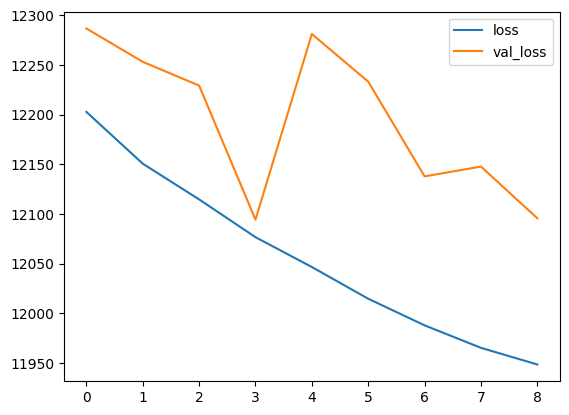

In [13]:
# Plot learning curve
pd.DataFrame(history.history).plot()
plt.show()

In [10]:
# Prepare the input data
X_train_formatted = [X_train['startingAirport'], X_train['destinationAirport'], X_train.drop(['startingAirport', 'destinationAirport'], axis=1)]
X_test_formatted = [X_test['startingAirport'], X_test['destinationAirport'], X_test.drop(['startingAirport', 'destinationAirport'], axis=1)]

In [11]:
predictions = model.predict(X_test_formatted)
predictions = predictions.flatten()
# Calculate the mean absolute error
mae = np.mean(np.abs(predictions - y_test))
print("Mean Absolute Error:", mae)

# Calculate the mean absolute percentage error
mape = np.mean(np.abs(predictions - y_test) / y_test)
print("Mean Absolute Percentage Error:", mape)

# Calculate the root mean squared error
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print("Root Mean Squared Error:", rmse)



  106/41058 ━━━━━━━━━━━━━━━━━━━━ 40s 979us/step  

/home/raytechie/Projects/adv_mla_at3/ml_experimentation/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['startingAirport', 'destinationAirport', 'otherFeatures']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


41058/41058 ━━━━━━━━━━━━━━━━━━━━ 34s 832us/step
Mean Absolute Error: 72.93785
Mean Absolute Percentage Error: 0.26078165
Root Mean Squared Error: 109.97325


In [63]:
import tensorflow as tf
# load the model
model_earlystop = tf.keras.models.load_model('../models/keras_model_early_stopping.keras')
model_earlystop.summary()

/home/raytechie/Projects/adv_mla_at3/ml_experimentation/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ startingAirport     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ destinationAirport  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 5)      │         80 │ startingAirport[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 5)      │         80 │ destinationAirpo… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 5)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 5)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ otherFeatures       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 17)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ otherFeatures[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      2,304 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,572 (84.27 KB)

 Trainable params: 10,785 (42.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,787 (42.14 KB)

In [65]:
# Alternatively, you can inspect specific layers
for layer in model_earlystop.layers:
    print(f"Layer Name: {layer.name}")
    print(f"Layer Type: {layer.__class__.__name__}")
    print(f"Layer Input Shape: {layer.input.shape if hasattr(layer.input, 'shape') else 'N/A'}")
    print(f"Layer Output Shape: {layer.output.shape if hasattr(layer.output, 'shape') else 'N/A'}")
    print(f"Layer Configuration: {layer.get_config()}")
    print("\n")

Layer Name: startingAirport
Layer Type: InputLayer
Layer Input Shape: N/A
Layer Output Shape: (None, 1)
Layer Configuration: {'batch_shape': (None, 1), 'dtype': 'float32', 'sparse': False, 'name': 'startingAirport'}


Layer Name: destinationAirport
Layer Type: InputLayer
Layer Input Shape: N/A
Layer Output Shape: (None, 1)
Layer Configuration: {'batch_shape': (None, 1), 'dtype': 'float32', 'sparse': False, 'name': 'destinationAirport'}


Layer Name: embedding
Layer Type: Embedding
Layer Input Shape: (None, 1)
Layer Output Shape: (None, 1, 5)
Layer Configuration: {'name': 'embedding', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'input_dim': 16, 'output_dim': 5, 'embeddings_initializer': {'module': 'keras.initializers', 'class_name': 'RandomUniform', 'config': {'seed': None, 'minval': -0.05, 'maxval': 0.05}, 'registered_name': None}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'emb

# Evaluate Results

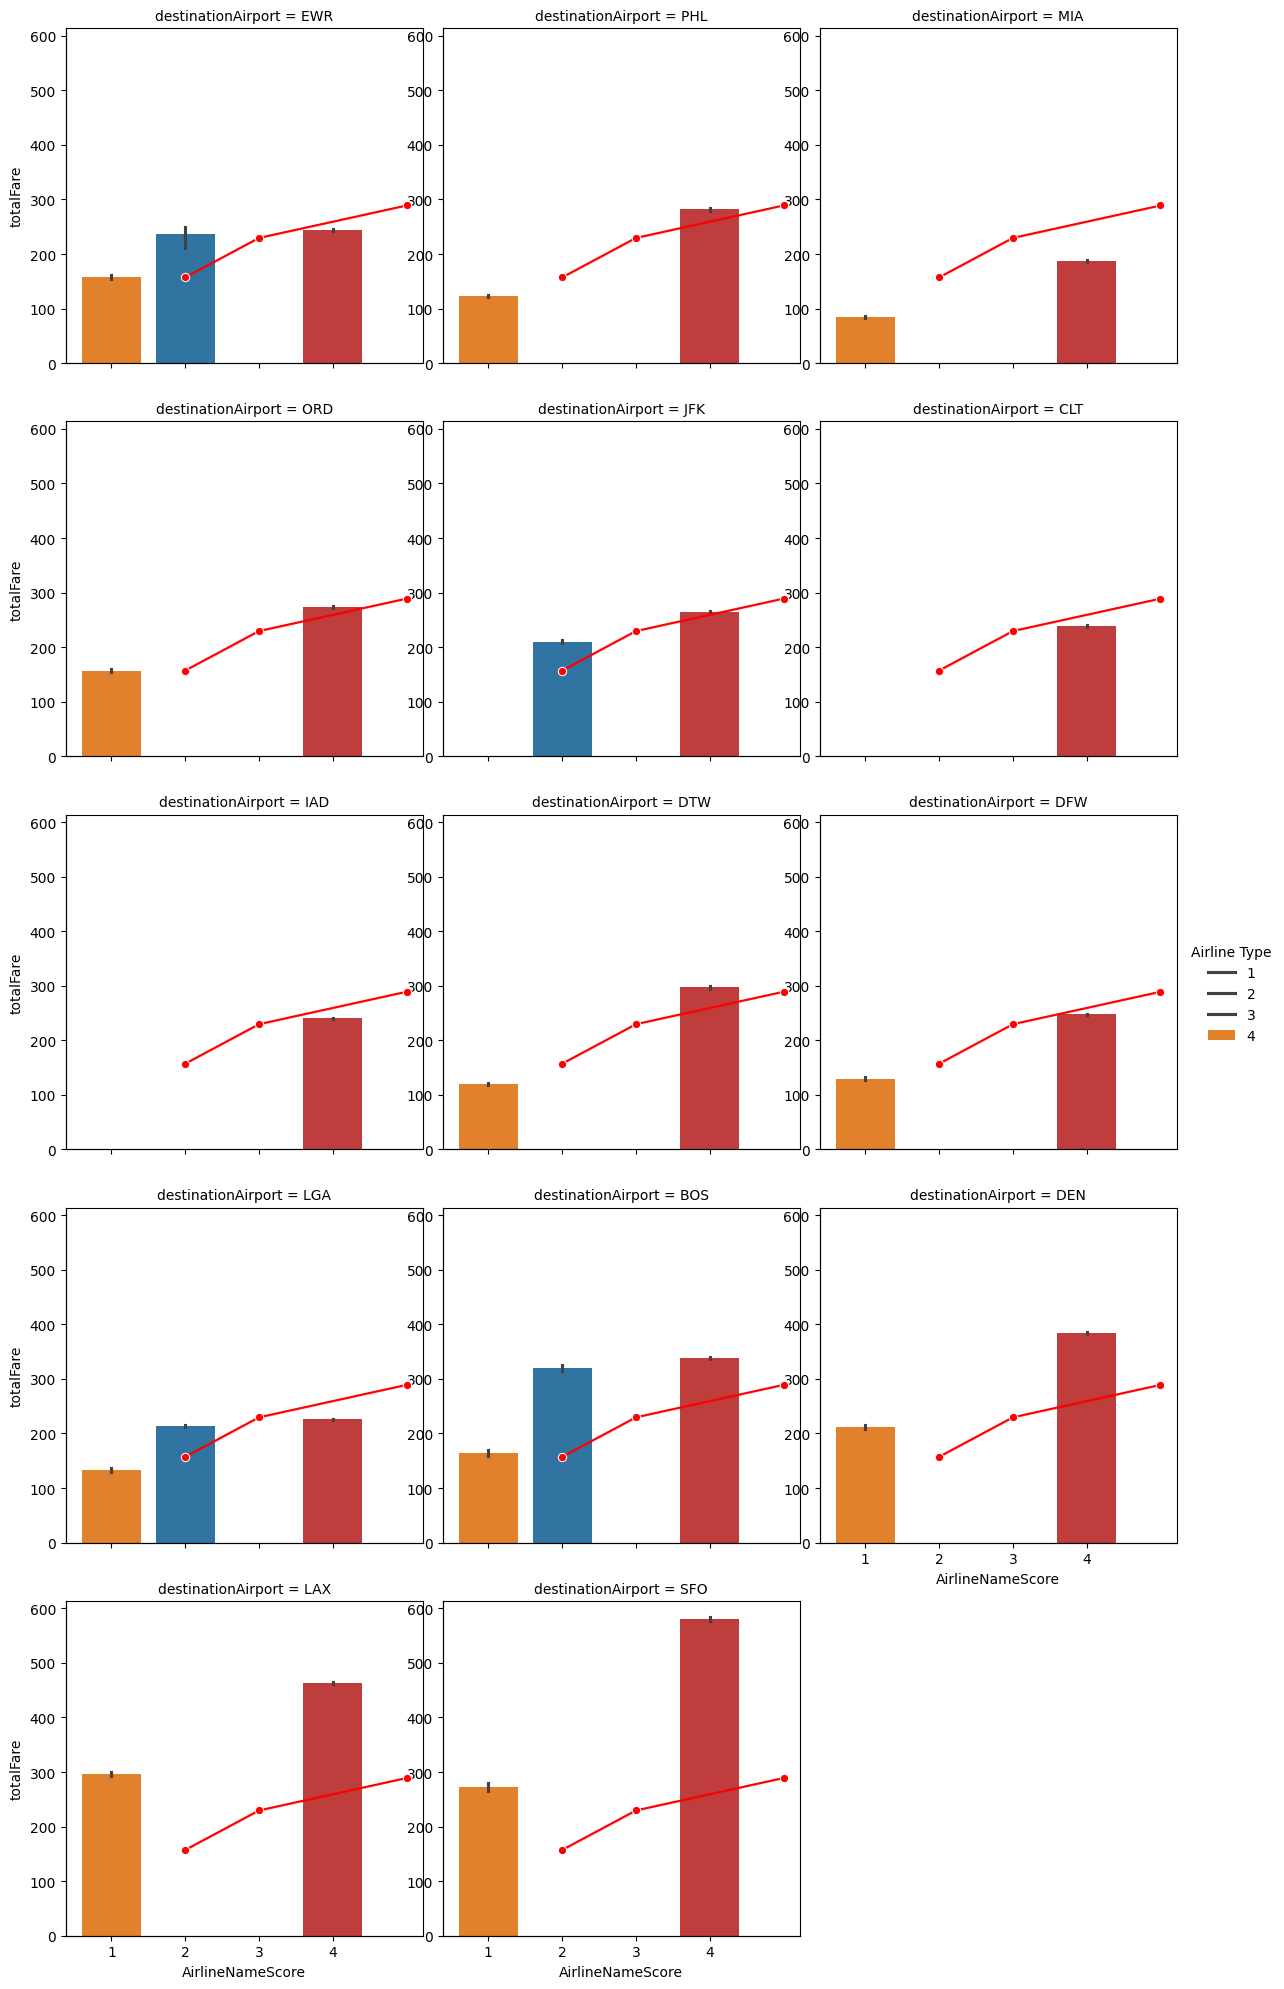

In [ ]:
import seaborn as sns

# Graph the avg prices by airline

# graph for economy cabine segment
filtered_df = df_train[(df_train['CabinCode'] == 1.0) & (df_train['startingAirport'] == 'ATL') & (df_train['isNonStop'] == 1)]

# Define a custom color palette
# Define colors for each airline type
type_colors = {
    1: '#ff7f0e',  # Ultra Low Cost
    2: '#1f77b4',  # Budget
    3: '#2ca02c',  # Regional
    4: '#d62728'   # Full Service
}
# Airline Encoding 
# 1: Ultra Low Cost, 2: Budget, 3: Regional, 4: Full Service


# Add a legend
legend_labels = {
    1: 'Ultra Low Cost',
    2: 'Budget',
    3: 'Regional',
    4: 'Full Service'
}


# palette for AirlineNameScore using type_colors
palette = {key: type_colors.get(key) for key in filtered_df['AirlineNameScore'].unique()}

# Create a FacetGrid to plot data for different destination airports
g = sns.FacetGrid(filtered_df, col='destinationAirport', col_wrap=3, height=4)
order_airlinetype = [1,2,3,4]

# Map the barplot to the FacetGrid with the custom color palette 
g.map_dataframe(sns.barplot, x='AirlineNameScore', y='totalFare', hue='AirlineNameScore', palette=palette, order=order_airlinetype)

for ax in g.axes.flat:
    ax2 = ax.twinx()  # Create a secondary y-axis
    sns.lineplot(x='AirlineNameScore', y='totalFare_pred', data=filtered_df, ax=ax2, color='red', marker='o')

    # Set the same y-limits for both axes
    y_min = min(ax.get_ylim()[0], ax2.get_ylim()[0])
    y_max = max(ax.get_ylim()[1], ax2.get_ylim()[1])
    ax.set_ylim(y_min, y_max)
    ax2.set_ylim(y_min, y_max)
    # Hide the secondary y-axis ticks and labels
    ax2.set_yticks([])
    ax2.set_ylabel('')


# Add a legend
g.add_legend(title='Airline Type', labels=legend_labels)



# Show the plot
plt.show()

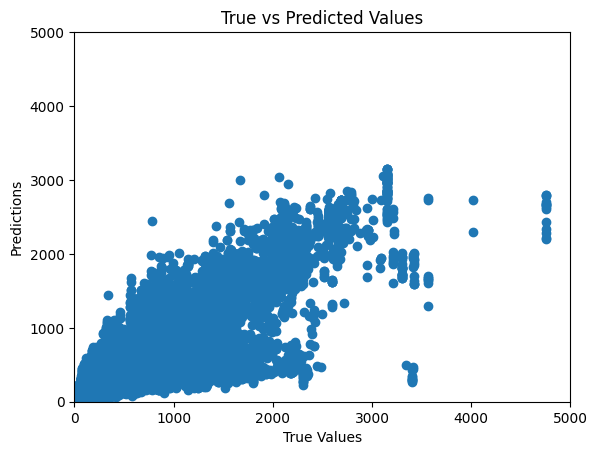

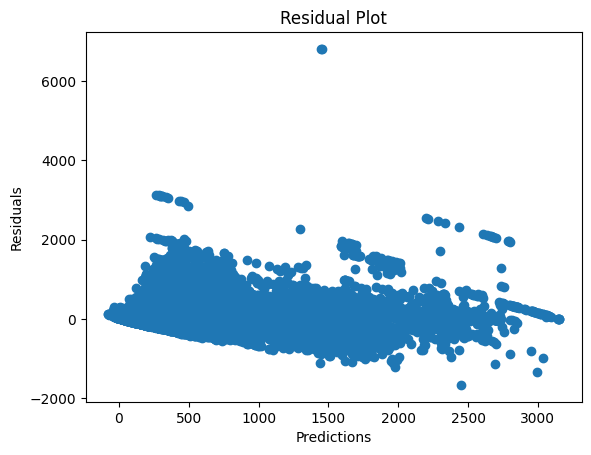

In [ ]:
import matplotlib.pyplot as plt
# Scatter plot of true vs predicted values
plt.scatter(y_test, predictions)



plt.xlim([0, 5000])
plt.ylim([0, 5000])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.show()

# Residual plot
residuals = y_test - predictions
plt.scatter(predictions, residuals)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

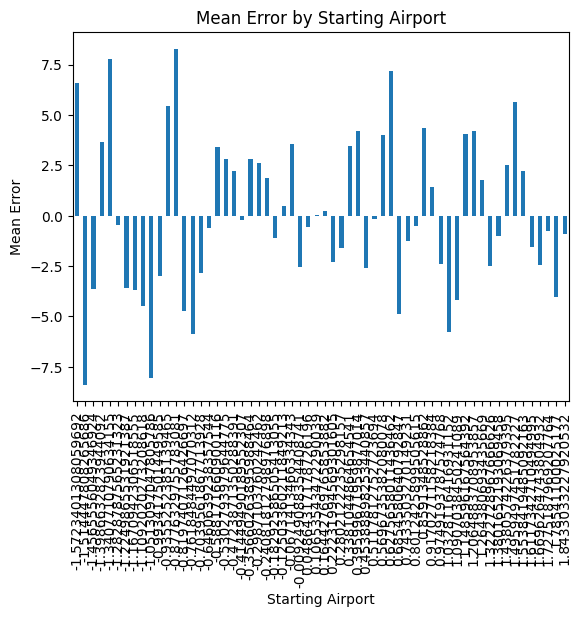

In [20]:
# Group errors by a specific feature (e.g., 'startingAirport')
error_df = pd.DataFrame({'True': y_test, 'Predicted': predictions, 'Error': y_test - predictions})
grouped_errors = error_df.groupby(X_test['date_diff_days']).mean()

# Plot mean error by 'startingAirport'
grouped_errors['Error'].plot(kind='bar')
plt.xlabel('Starting Airport')
plt.ylabel('Mean Error')
plt.title('Mean Error by Starting Airport')
plt.show()

I think its handling outlier predictions badly like regional (which might involve more distance). Its also confused by the cabin code

In [14]:
import numpy as np
from tensorflow.keras.models import Model

# Extract the embedding layers
starting_airport_embedding_layer = model.get_layer('embedding')
destination_airport_embedding_layer = model.get_layer('embedding_1')

# Create models to output the embeddings
starting_airport_embedding_model = Model(inputs=model.input, outputs=starting_airport_embedding_layer.output)
destination_airport_embedding_model = Model(inputs=model.input, outputs=destination_airport_embedding_layer.output)

# Get the weights of the embedding layers
starting_airport_embeddings = starting_airport_embedding_layer.get_weights()[0]
destination_airport_embeddings = destination_airport_embedding_layer.get_weights()[0]

# Rename the airport indexes using le

starting_airport_index = {i: le.inverse_transform([i])[0] for i in range(starting_airport_embeddings.shape[0])}
destination_airport_index = {i: le.inverse_transform([i])[0] for i in range(destination_airport_embeddings.shape[0])}


In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# Check the number of samples in the embeddings
num_samples_starting = starting_airport_embeddings.shape[0]
num_samples_destination = destination_airport_embeddings.shape[0]

# Set perplexity to a value less than the number of samples
perplexity_value = min(num_samples_starting, num_samples_destination) - 1

# Reduce dimensionality of embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
starting_airport_embeddings_2d = tsne.fit_transform(starting_airport_embeddings)
destination_airport_embeddings_2d = tsne.fit_transform(destination_airport_embeddings)

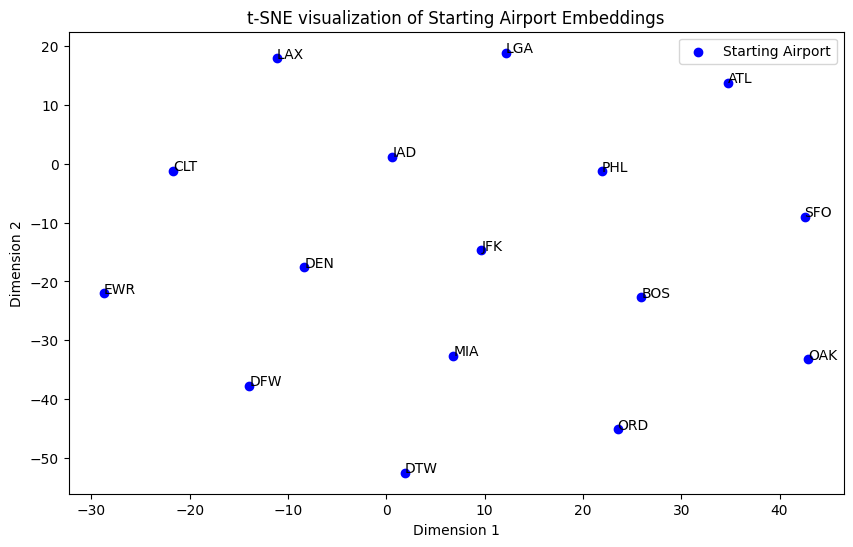

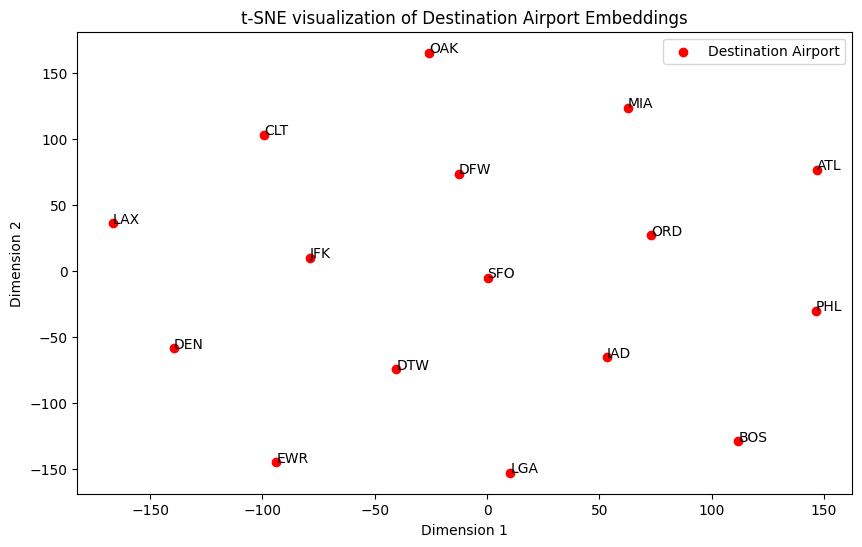

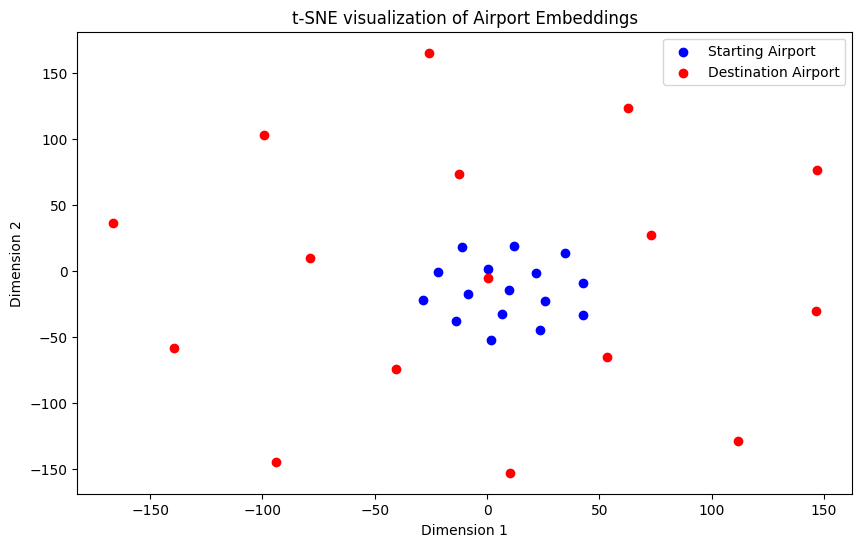

IndexError: index 16 is out of bounds for axis 0 with size 16

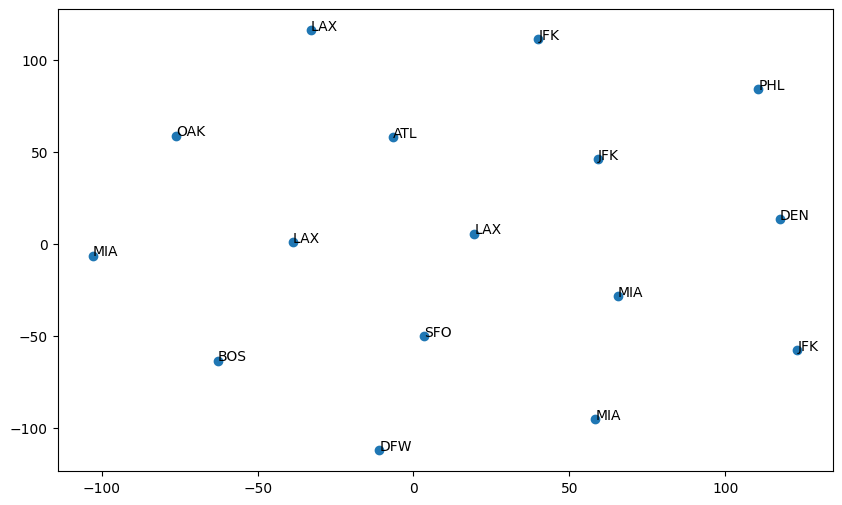

In [18]:
# Plot startingAirport embeddings
plt.figure(figsize=(10, 6))
plt.scatter(starting_airport_embeddings_2d[:, 0], starting_airport_embeddings_2d[:, 1], c='blue', label='Starting Airport')
for i, label in enumerate(range(starting_airport_embeddings.shape[0])):
    # Annotate the points with the airport from le
    label = le.inverse_transform([label])[0]
    plt.annotate(label, (starting_airport_embeddings_2d[i, 0], starting_airport_embeddings_2d[i, 1]))
plt.title('t-SNE visualization of Starting Airport Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

# Plot destinationAirport embeddings
plt.figure(figsize=(10, 6))
plt.scatter(destination_airport_embeddings_2d[:, 0], destination_airport_embeddings_2d[:, 1], c='red', label='Destination Airport')
for i, label in enumerate(range(destination_airport_embeddings.shape[0])):
    # Annotate the points with the airport from le
    label = le.inverse_transform([label])[0]
    plt.annotate(label, (destination_airport_embeddings_2d[i, 0], destination_airport_embeddings_2d[i, 1]))
plt.title('t-SNE visualization of Destination Airport Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

# plot the combined embeddings
plt.figure(figsize=(10, 6))
plt.scatter(starting_airport_embeddings_2d[:, 0], starting_airport_embeddings_2d[:, 1], c='blue', label='Starting Airport')
plt.scatter(destination_airport_embeddings_2d[:, 0], destination_airport_embeddings_2d[:, 1], c='red', label='Destination Airport')
plt.title('t-SNE visualization of Airport Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

#visualise the concatenated embeddings


# Concatenate the embeddings
concatenated_embeddings = np.concatenate([starting_airport_embeddings, destination_airport_embeddings], axis=1)

# Reduce dimensionality of concatenated embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
concatenated_embeddings_2d = tsne.fit_transform(concatenated_embeddings)

# Plot concatenated embeddings
plt.figure(figsize=(10, 6))
plt.scatter(concatenated_embeddings_2d[:, 0], concatenated_embeddings_2d[:, 1])
# Annotate the airport points from le
for i, label in enumerate(X_test['startingAirport']):
    label = le.inverse_transform([label])[0]
    plt.annotate(label, (concatenated_embeddings_2d[i, 0], concatenated_embeddings_2d[i, 1]))
for i, label in enumerate(X_test['destinationAirport']):
    label = le.inverse_transform([label])[0]
    plt.annotate(label, (concatenated_embeddings_2d[i, 0], concatenated_embeddings_2d[i, 1]))
    

plt.title('t-SNE visualization of Concatenated Airport Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()




In [34]:
from scipy.spatial.distance import euclidean

# Function to calculate the distance between two airports
def calculate_distance(airport1, airport2, embeddings):
    return euclidean(embeddings[airport1], embeddings[airport2])

# Example: Calculate the distance between airport 0 and airport 1
distance = calculate_distance(9, 12, starting_airport_embeddings)
print(f"Distance between airport 0 and airport 1: {distance}")

Distance between airport 0 and airport 1: 3.362314224243164


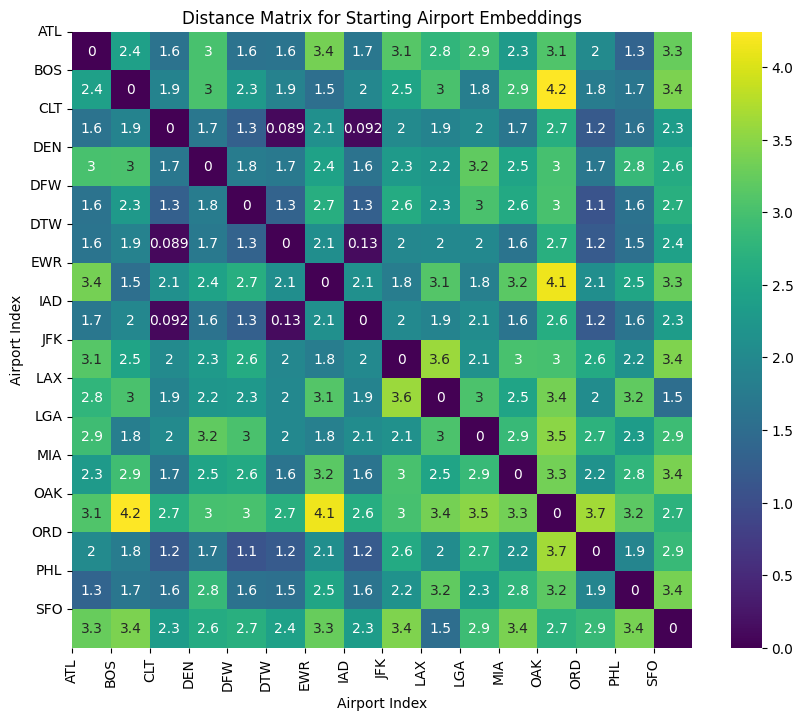

In [36]:
import numpy as np
import seaborn as sns

# Calculate the distance matrix for startingAirport embeddings
num_airports = starting_airport_embeddings.shape[0]
distance_matrix = np.zeros((num_airports, num_airports))

for i in range(num_airports):
    for j in range(num_airports):
        distance_matrix[i, j] = calculate_distance(i, j, starting_airport_embeddings)

# Plot the distance matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=True, cmap='viridis')
plt.title('Distance Matrix for Starting Airport Embeddings')
#rename index using le
Airport_rename = {i: le.inverse_transform([i])[0] for i in range(starting_airport_embeddings.shape[0])}
plt.xticks(ticks=range(num_airports), labels=[Airport_rename[i] for i in range(num_airports)], rotation=90)
plt.yticks(ticks=range(num_airports), labels=[Airport_rename[i] for i in range(num_airports)], rotation=0)

plt.xlabel('Airport Index')
plt.ylabel('Airport Index')

# relabel index using le
plt.show()

In [37]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model
from scikeras.wrappers import KerasRegressor

# Sample data for demonstration
X_train = pd.DataFrame({
    'startingAirport': ['A', 'B', 'A', 'C', 'B'],
    'destinationAirport': ['X', 'Y', 'X', 'Z', 'Y'],
    'otherFeature1': [1, 2, 3, 4, 5],
    'otherFeature2': [5, 4, 3, 2, 1]
})
y_train = np.array([100, 200, 150, 300, 250])

X_test = pd.DataFrame({
    'startingAirport': ['A', 'B'],
    'destinationAirport': ['X', 'Y'],
    'otherFeature1': [1, 2],
    'otherFeature2': [5, 4]
})
y_test = np.array([120, 220])

# Define a function to create the Keras model
def create_model():
    startingAirport_input = Input(shape=(1,), name='startingAirport')
    destinationAirport_input = Input(shape=(1,), name='destinationAirport')
    other_features_input = Input(shape=(X_train.shape[1] - 2,), name='otherFeatures')
    print('other_features',other_features_input.shape)

    startingAirport_embedding = Embedding(input_dim=len(np.unique(X_train['startingAirport'])), output_dim=5)(startingAirport_input)
    destinationAirport_embedding = Embedding(input_dim=len(np.unique(X_train['destinationAirport'])), output_dim=5)(destinationAirport_input)
    

    startingAirport_flatten = Flatten()(startingAirport_embedding)
    destinationAirport_flatten = Flatten()(destinationAirport_embedding)



    concat = Concatenate()([startingAirport_flatten, destinationAirport_flatten, other_features_input])
    print('concat',concat.shape)
    
    dense1 = Dense(128, activation='relu')(concat)
    dense2 = Dense(64, activation='relu')(dense1)
    output = Dense(1)(dense2)

    model = Model(inputs=[startingAirport_input, destinationAirport_input, other_features_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the model
model = create_model()

# Print the model summary
model.summary()

# Print input layer configurations
for layer in model.layers:
    if layer.__class__.__name__ == 'InputLayer':
        for tensor in layer.input:
            print(f"Layer {layer.name} expects input shape: {tensor.shape}")

# Check the model's input shape attributes
for input_layer in model.inputs:
    print(f"Input layer {input_layer.name} expects shape: {input_layer.shape}")

# Wrap the Keras model with SciKeras
nn = KerasRegressor(model=create_model, epochs=10, batch_size=32)

# Ensure the input data is correctly formatted
X_train_formatted = [X_train['startingAirport'].values.reshape(-1, 1), X_train['destinationAirport'].values.reshape(-1, 1), X_train.drop(columns=['startingAirport', 'destinationAirport']).values]
X_test_formatted = [X_test['startingAirport'].values.reshape(-1, 1), X_test['destinationAirport'].values.reshape(-1, 1), X_test.drop(columns=['startingAirport', 'destinationAirport']).values]

# Print debug information
print("X_train_formatted shapes:", [x.shape for x in X_train_formatted])
print("X_train_formatted types:", [type(x) for x in X_train_formatted])
print("X_test_formatted shapes:", [x.shape for x in X_test_formatted])
print("X_test_formatted types:", [type(x) for x in X_test_formatted])

# Fit the model
nn.fit(X_train_formatted, y_train)

# Evaluate the model
score = nn.score(X_test_formatted, y_test)
print("Score:", score)

# Plot learning curve
pd.DataFrame(nn.model_.history.history).plot()

other_features (None, 2)
concat (None, 12)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ startingAirport     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ destinationAirport  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_18        │ (None, 1, 5)      │         15 │ startingAirport[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_19        │ (None, 1, 5)      │         15 │ destinationAirpo… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_18          │ (None, 5)         │          0 │ embedding_18[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_19          │ (None, 5)         │          0 │ embedding_19[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ otherFeatures       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 12)        │          0 │ flatten_18[0][0], │
│ (Concatenate)       │                   │            │ flatten_19[0][0], │
│                     │                   │            │ otherFeatures[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 128)       │      1,664 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 64)        │      8,256 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 1)         │         65 │ dense_28[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,015 (39.12 KB)

 Trainable params: 10,015 (39.12 KB)

 Non-trainable params: 0 (0.00 B)

Input layer startingAirport expects shape: (None, 1)
Input layer destinationAirport expects shape: (None, 1)
Input layer otherFeatures expects shape: (None, 2)
X_train_formatted shapes: [(5, 1), (5, 1), (5, 2)]
X_train_formatted types: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
X_test_formatted shapes: [(2, 1), (2, 1), (2, 2)]
X_test_formatted types: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 5) + inhomogeneous part.

In [38]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model
from scikeras.wrappers import KerasRegressor

# Sample data for demonstration
X_train = pd.DataFrame({
    'startingAirport': ['A', 'B', 'A', 'C', 'B'],
    'destinationAirport': ['X', 'Y', 'X', 'Z', 'Y'],
    'otherFeature1': [1, 2, 3, 4, 5],
    'otherFeature2': [5, 4, 3, 2, 1]
})
y_train = np.array([100, 200, 150, 300, 250])

X_test = pd.DataFrame({
    'startingAirport': ['A', 'B'],
    'destinationAirport': ['X', 'Y'],
    'otherFeature1': [1, 2],
    'otherFeature2': [5, 4]
})
y_test = np.array([120, 220])

# Define a function to create the Keras model
def create_model():
    startingAirport_input = Input(shape=(1,), name='startingAirport')
    destinationAirport_input = Input(shape=(1,), name='destinationAirport')
    other_features_input = Input(shape=(X_train.shape[1] - 2,), name='otherFeatures')

    startingAirport_embedding = Embedding(input_dim=len(np.unique(X_train['startingAirport'])), output_dim=5)(startingAirport_input)
    destinationAirport_embedding = Embedding(input_dim=len(np.unique(X_train['destinationAirport'])), output_dim=5)(destinationAirport_input)

    startingAirport_flatten = Flatten()(startingAirport_embedding)
    destinationAirport_flatten = Flatten()(destinationAirport_embedding)

    concat = Concatenate()([startingAirport_flatten, destinationAirport_flatten, other_features_input])

    dense1 = Dense(128, activation='relu')(concat)
    dense2 = Dense(64, activation='relu')(dense1)
    output = Dense(1)(dense2)

    model = Model(inputs=[startingAirport_input, destinationAirport_input, other_features_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the model
model = create_model()

# Print the model summary
model.summary()

# Print input layer configurations
for layer in model.layers:
    if layer.__class__.__name__ == 'InputLayer':
        for tensor in layer.input:
            print(f"Layer {layer.name} expects input shape: {tensor.shape}")

# Check the model's input shape attributes
for input_layer in model.inputs:
    print(f"Input layer {input_layer.name} expects shape: {input_layer.shape}")

# Wrap the Keras model with SciKeras
nn = KerasRegressor(model=create_model, epochs=10, batch_size=32)

# Ensure the input data is correctly formatted
X_train_formatted = [
    X_train['startingAirport'].values.reshape(-1, 1),
    X_train['destinationAirport'].values.reshape(-1, 1),
    X_train.drop(columns=['startingAirport', 'destinationAirport']).values
]
X_test_formatted = [
    X_test['startingAirport'].values.reshape(-1, 1),
    X_test['destinationAirport'].values.reshape(-1, 1),
    X_test.drop(columns=['startingAirport', 'destinationAirport']).values
]

# Print debug information
print("X_train_formatted shapes:", [x.shape for x in X_train_formatted])
print("X_train_formatted types:", [type(x) for x in X_train_formatted])
print("X_test_formatted shapes:", [x.shape for x in X_test_formatted])
print("X_test_formatted types:", [type(x) for x in X_test_formatted])

# Check for NaN or infinite values
print("NaN values in X_train_formatted:", [np.isnan(x).any() for x in X_train_formatted])
print("Infinite values in X_train_formatted:", [np.isinf(x).any() for x in X_train_formatted])

# Print sample data
print("Sample X_train_formatted:", [x[:5] for x in X_train_formatted])
print("Sample y_train:", y_train[:5])

# Fit the model
nn.fit(X_train_formatted, y_train)

# Evaluate the model
score = nn.score(X_test_formatted, y_test)
print("Score:", score)

# Plot learning curve
pd.DataFrame(nn.model_.history.history).plot()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ startingAirport     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ destinationAirport  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_20        │ (None, 1, 5)      │         15 │ startingAirport[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_21        │ (None, 1, 5)      │         15 │ destinationAirpo… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_20          │ (None, 5)         │          0 │ embedding_20[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_21          │ (None, 5)         │          0 │ embedding_21[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ otherFeatures       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 12)        │          0 │ flatten_20[0][0], │
│ (Concatenate)       │                   │            │ flatten_21[0][0], │
│                     │                   │            │ otherFeatures[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 128)       │      1,664 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 64)        │      8,256 │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 1)         │         65 │ dense_31[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,015 (39.12 KB)

 Trainable params: 10,015 (39.12 KB)

 Non-trainable params: 0 (0.00 B)

Input layer startingAirport expects shape: (None, 1)
Input layer destinationAirport expects shape: (None, 1)
Input layer otherFeatures expects shape: (None, 2)
X_train_formatted shapes: [(5, 1), (5, 1), (5, 2)]
X_train_formatted types: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
X_test_formatted shapes: [(2, 1), (2, 1), (2, 2)]
X_test_formatted types: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model
from scikeras.wrappers import KerasRegressor

# Sample data for demonstration
X_train = pd.DataFrame({
    'startingAirport': ['A', 'B', 'A', 'C', 'B'],
    'destinationAirport': ['X', 'Y', 'X', 'Z', 'Y'],
    'otherFeature1': [1, 2, 3, 4, 5],
    'otherFeature2': [5, 4, 3, 2, 1]
})
y_train = np.array([100, 200, 150, 300, 250])

X_test = pd.DataFrame({
    'startingAirport': ['A', 'B'],
    'destinationAirport': ['X', 'Y'],
    'otherFeature1': [1, 2],
    'otherFeature2': [5, 4]
})
y_test = np.array([120, 220])

# Convert categorical columns to numerical values
le_starting = LabelEncoder()
le_destination = LabelEncoder()

X_train['startingAirport'] = le_starting.fit_transform(X_train['startingAirport'])
X_train['destinationAirport'] = le_destination.fit_transform(X_train['destinationAirport'])

X_test['startingAirport'] = le_starting.transform(X_test['startingAirport'])
X_test['destinationAirport'] = le_destination.transform(X_test['destinationAirport'])

# Define a function to create the Keras model
def create_model():
    startingAirport_input = Input(shape=(1,), name='startingAirport')
    destinationAirport_input = Input(shape=(1,), name='destinationAirport')
    other_features_input = Input(shape=(X_train.shape[1] - 2,), name='otherFeatures')

    startingAirport_embedding = Embedding(input_dim=len(np.unique(X_train['startingAirport'])), output_dim=5)(startingAirport_input)
    destinationAirport_embedding = Embedding(input_dim=len(np.unique(X_train['destinationAirport'])), output_dim=5)(destinationAirport_input)

    startingAirport_flatten = Flatten()(startingAirport_embedding)
    destinationAirport_flatten = Flatten()(destinationAirport_embedding)

    concat = Concatenate()([startingAirport_flatten, destinationAirport_flatten, other_features_input])

    dense1 = Dense(128, activation='relu')(concat)
    dense2 = Dense(64, activation='relu')(dense1)
    output = Dense(1)(dense2)

    model = Model(inputs=[startingAirport_input, destinationAirport_input, other_features_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the model
model = create_model()

# Print the model summary
model.summary()

# Print input layer configurations
for layer in model.layers:
    if layer.__class__.__name__ == 'InputLayer':
        for tensor in layer.input:
            print(f"Layer {layer.name} expects input shape: {tensor.shape}")

# Check the model's input shape attributes
for input_layer in model.inputs:
    print(f"Input layer {input_layer.name} expects shape: {input_layer.shape}")

# Wrap the Keras model with SciKeras
nn = KerasRegressor(model=create_model, epochs=10, batch_size=32)

# Ensure the input data is correctly formatted
X_train_formatted = [
    X_train['startingAirport'].values.reshape(-1, 1),
    X_train['destinationAirport'].values.reshape(-1, 1),
    X_train.drop(columns=['startingAirport', 'destinationAirport']).values
]
X_test_formatted = [
    X_test['startingAirport'].values.reshape(-1, 1),
    X_test['destinationAirport'].values.reshape(-1, 1),
    X_test.drop(columns=['startingAirport', 'destinationAirport']).values
]

# Print debug information
print("X_train_formatted shapes:", [x.shape for x in X_train_formatted])
print("X_train_formatted types:", [type(x) for x in X_train_formatted])
print("X_test_formatted shapes:", [x.shape for x in X_test_formatted])
print("X_test_formatted types:", [type(x) for x in X_test_formatted])

# Check for NaN or infinite values
print("NaN values in X_train_formatted:", [np.isnan(x).any() for x in X_train_formatted])
print("Infinite values in X_train_formatted:", [np.isinf(x).any() for x in X_train_formatted])

# Print sample data
print("Sample X_train_formatted:", [x[:5] for x in X_train_formatted])
print("Sample y_train:", y_train[:5])

# Fit the model
nn.fit(X_train_formatted, y_train)

# Evaluate the model
score = nn.score(X_test_formatted, y_test)
print("Score:", score)

# Plot learning curve
pd.DataFrame(nn.model_.history.history).plot()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ startingAirport     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ destinationAirport  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_22        │ (None, 1, 5)      │         15 │ startingAirport[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_23        │ (None, 1, 5)      │         15 │ destinationAirpo… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_22          │ (None, 5)         │          0 │ embedding_22[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_23          │ (None, 5)         │          0 │ embedding_23[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ otherFeatures       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 12)        │          0 │ flatten_22[0][0], │
│ (Concatenate)       │                   │            │ flatten_23[0][0], │
│                     │                   │            │ otherFeatures[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 128)       │      1,664 │ concatenate_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 64)        │      8,256 │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 1)         │         65 │ dense_34[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,015 (39.12 KB)

 Trainable params: 10,015 (39.12 KB)

 Non-trainable params: 0 (0.00 B)

Input layer startingAirport expects shape: (None, 1)
Input layer destinationAirport expects shape: (None, 1)
Input layer otherFeatures expects shape: (None, 2)
X_train_formatted shapes: [(5, 1), (5, 1), (5, 2)]
X_train_formatted types: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
X_test_formatted shapes: [(2, 1), (2, 1), (2, 2)]
X_test_formatted types: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
NaN values in X_train_formatted: [False, False, False]
Infinite values in X_train_formatted: [False, False, False]
Sample X_train_formatted: [array([[0],
       [1],
       [0],
       [2],
       [1]]), array([[0],
       [1],
       [0],
       [2],
       [1]]), array([[1, 5],
       [2, 4],
       [3, 3],
       [4, 2],
       [5, 1]])]
Sample y_train: [100 200 150 300 250]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 5) + inhomogeneous part.

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ startingAirport     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ destinationAirport  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_24        │ (None, 1, 5)      │         15 │ startingAirport[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_25        │ (None, 1, 5)      │         15 │ destinationAirpo… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_24          │ (None, 5)         │          0 │ embedding_24[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_25          │ (None, 5)         │          0 │ embedding_25[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ otherFeatures       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 12)        │          0 │ flatten_24[0][0], │
│ (Concatenate)       │                   │            │ flatten_25[0][0], │
│                     │                   │            │ otherFeatures[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 128)       │      1,664 │ concatenate_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 64)        │      8,256 │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 1)         │         65 │ dense_37[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,015 (39.12 KB)

 Trainable params: 10,015 (39.12 KB)

 Non-trainable params: 0 (0.00 B)

Input layer startingAirport expects shape: (None, 1)
Input layer destinationAirport expects shape: (None, 1)
Input layer otherFeatures expects shape: (None, 2)
X_train_formatted shapes: [(5, 1), (5, 1), (5, 2)]
X_train_formatted types: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
X_test_formatted shapes: [(2, 1), (2, 1), (2, 2)]
X_test_formatted types: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
NaN values in X_train_formatted: [False, False, False]
Infinite values in X_train_formatted: [False, False, False]
Sample X_train_formatted: [array([[0],
       [1],
       [0],
       [2],
       [1]]), array([[0],
       [1],
       [0],
       [2],
       [1]]), array([[1, 5],
       [2, 4],
       [3, 3],
       [4, 2],
       [5, 1]])]
Sample y_train: [100 200 150 300 250]
Epoch 1/10


/home/raytechie/Projects/adv_mla_at3/ml_experimentation/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['startingAirport', 'destinationAirport', 'otherFeatures']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 44876.1250 - val_loss: 31308.4023
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 44816.5312 - val_loss: 31258.3770
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 44758.4258 - val_loss: 31214.7812
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 44702.5078 - val_loss: 31173.3730
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 44648.3398 - val_loss: 31132.3594
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 44594.8516 - val_loss: 31091.3496
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 44541.8047 - val_loss: 31051.0879
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 44489.0312 - val_loss: 31012.5410
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 44436.9531 - val_loss: 30974.8926
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 44384.6172 - val_loss: 30935.1797
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 30935.1797
Score: 30935.1796875


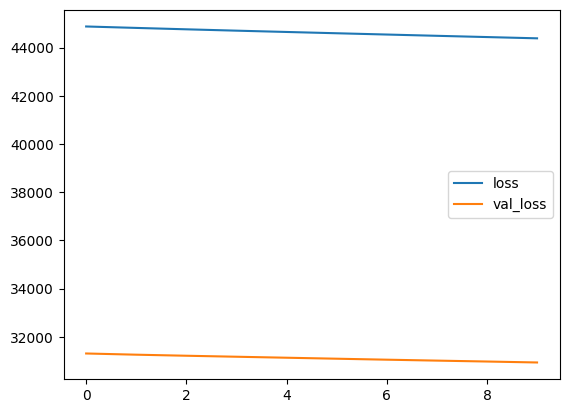

In [40]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Sample data for demonstration
X_train = pd.DataFrame({
    'startingAirport': ['A', 'B', 'A', 'C', 'B'],
    'destinationAirport': ['X', 'Y', 'X', 'Z', 'Y'],
    'otherFeature1': [1, 2, 3, 4, 5],
    'otherFeature2': [5, 4, 3, 2, 1]
})
y_train = np.array([100, 200, 150, 300, 250])

X_test = pd.DataFrame({
    'startingAirport': ['A', 'B'],
    'destinationAirport': ['X', 'Y'],
    'otherFeature1': [1, 2],
    'otherFeature2': [5, 4]
})
y_test = np.array([120, 220])

# Convert categorical columns to numerical values
le_starting = LabelEncoder()
le_destination = LabelEncoder()

X_train['startingAirport'] = le_starting.fit_transform(X_train['startingAirport'])
X_train['destinationAirport'] = le_destination.fit_transform(X_train['destinationAirport'])

X_test['startingAirport'] = le_starting.transform(X_test['startingAirport'])
X_test['destinationAirport'] = le_destination.transform(X_test['destinationAirport'])

# Define a function to create the Keras model
def create_model():
    startingAirport_input = Input(shape=(1,), name='startingAirport')
    destinationAirport_input = Input(shape=(1,), name='destinationAirport')
    other_features_input = Input(shape=(X_train.shape[1] - 2,), name='otherFeatures')

    startingAirport_embedding = Embedding(input_dim=len(np.unique(X_train['startingAirport'])), output_dim=5)(startingAirport_input)
    destinationAirport_embedding = Embedding(input_dim=len(np.unique(X_train['destinationAirport'])), output_dim=5)(destinationAirport_input)

    startingAirport_flatten = Flatten()(startingAirport_embedding)
    destinationAirport_flatten = Flatten()(destinationAirport_embedding)

    concat = Concatenate()([startingAirport_flatten, destinationAirport_flatten, other_features_input])

    dense1 = Dense(128, activation='relu')(concat)
    dense2 = Dense(64, activation='relu')(dense1)
    output = Dense(1)(dense2)

    model = Model(inputs=[startingAirport_input, destinationAirport_input, other_features_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the model
model = create_model()

# Print the model summary
model.summary()

# Print input layer configurations
for layer in model.layers:
    if layer.__class__.__name__ == 'InputLayer':
        for tensor in layer.input:
            print(f"Layer {layer.name} expects input shape: {tensor.shape}")

# Check the model's input shape attributes
for input_layer in model.inputs:
    print(f"Input layer {input_layer.name} expects shape: {input_layer.shape}")

# Ensure the input data is correctly formatted
X_train_formatted = [
    X_train['startingAirport'].values.reshape(-1, 1),
    X_train['destinationAirport'].values.reshape(-1, 1),
    X_train.drop(columns=['startingAirport', 'destinationAirport']).values
]
X_test_formatted = [
    X_test['startingAirport'].values.reshape(-1, 1),
    X_test['destinationAirport'].values.reshape(-1, 1),
    X_test.drop(columns=['startingAirport', 'destinationAirport']).values
]

# Print debug information
print("X_train_formatted shapes:", [x.shape for x in X_train_formatted])
print("X_train_formatted types:", [type(x) for x in X_train_formatted])
print("X_test_formatted shapes:", [x.shape for x in X_test_formatted])
print("X_test_formatted types:", [type(x) for x in X_test_formatted])

# Check for NaN or infinite values
print("NaN values in X_train_formatted:", [np.isnan(x).any() for x in X_train_formatted])
print("Infinite values in X_train_formatted:", [np.isinf(x).any() for x in X_train_formatted])

# Print sample data
print("Sample X_train_formatted:", [x[:5] for x in X_train_formatted])
print("Sample y_train:", y_train[:5])

# Fit the model
history = model.fit(X_train_formatted, y_train, epochs=10, batch_size=32, validation_data=(X_test_formatted, y_test))

# Evaluate the model
score = model.evaluate(X_test_formatted, y_test)
print("Score:", score)

# Plot learning curve
pd.DataFrame(history.history).plot()
plt.show()

In [17]:
########################################################################################################################
# 3. Create Pipelines
########################################################################################################################
# Standard Scaler
preprocessing = [('scaler', StandardScaler())]

# Scikitlearn Pipelines
# Linear Regression Pipeline
sklearn_pipeline= Pipeline(preprocessing + [('model', linear_regression)])

# LightGBM Pipeline
lgbm_pipeline = Pipeline(preprocessing + [('model', lgbm)])

# Tensorflow Pipeline
tf_pipeline = Pipeline(preprocessing + [('model', nn)])


In [20]:
########################################################################################################################
# 4. Train and Evaluate Pipleines
########################################################################################################################
# Linear Regression
sklearn_pipeline.fit(X_train, y_train)
sklearn_pipeline.score(X_test, y_test)

# LightGBM
lgbm_pipeline.fit(X_train, y_train)
lgbm_pipeline.score(X_test, y_test)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 5255408, number of used features: 9
[LightGBM] [Info] Start training from score 331.521755


0.6213505654229615

In [23]:
# Tensorflow
tf_pipeline.fit(X_train, y_train)
tf_pipeline.score(X_test, y_test)
# Plot learning curve
pd.DataFrame(tf_pipeline.model.history.history).plot()

Epoch 1/10


ValueError: Layer "functional_1" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(None, 9) dtype=float32>]

In [ ]:



########################################################################################################################
# 5. Save the model
########################################################################################################################

joblib.dump(sklearn_pipeline, '../models/linear_regression.pkl')
joblib.dump(lgbm_pipeline, '../models/lgbm.pkl')
tf_pipeline.model.save('../models/tf_nn.h5')

########################################################################################################################
# 5. Load the model
########################################################################################################################
import joblib
from tensorflow.keras.models import load_model

sklearn_pipeline = joblib.load('../models/linear_regression.pkl')
lgbm_pipeline = joblib.load('../models/lgbm.pkl')
tf_pipeline = load_model('../models/tf_nn.h5')







